In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{libertine}\usepackage{sansmath}\sansmath")
params = {"axes.labelsize": 9, "xtick.labelsize": 9, "ytick.labelsize": 9}
plt.rcParams.update(params)

# Load input data

Cycle color distance data, survey input cycles, and cycle order in survey

In [3]:
with open("cycle-comparison.json") as infile:
    cycleDist = json.load(infile)['results']

In [4]:
with open("anglesorderplotnum.js") as infile:
    line = infile.readlines()[1].split("[")[1].split("]")[0]
    order = np.array([int(i) for i in line.split(",")])

In [5]:
with open("cycles_in_best_order.js") as infile:
    cyclesBestOrder = json.loads(infile.read().split("=")[1][1:-2])

In [6]:
numColor = np.array([cyclesBestOrder[i][0][1] for i in order])

In [7]:
# min_dists, min_dists_typ, min_dists_deut, min_dists_prot, min_dists_trit
minDeltaE = []
for i in order:
    dE = np.array(cycleDist[cyclesBestOrder[i][0][0]])[:, cyclesBestOrder[i][0][1] - 1]
    minDeltaE.append(dE[0])
minDeltaE = np.array(minDeltaE)

# Load survey response data

In [8]:
responses = {
    "typ": [],
    "deut": [],
    "prot": [],
    "trit": [],
}
with open("log.txt") as infile:
    for line in infile.readlines():
        resp = json.loads(line)
        responses[resp["cvdType"]].append(np.array(resp["responses"]).T)

# Find responses where the response exceeded the actual number of classes

In [9]:
total = 0
negative = 0
for visType in responses:
    negative += np.sum(numColor - np.array(responses[visType])[:, 0] < 0)
    total += np.array(responses[visType])[:, 0].size
print(f"{negative} / {total} = {negative / total * 100:.0f}%")

14 / 784 = 2%


# Plot results

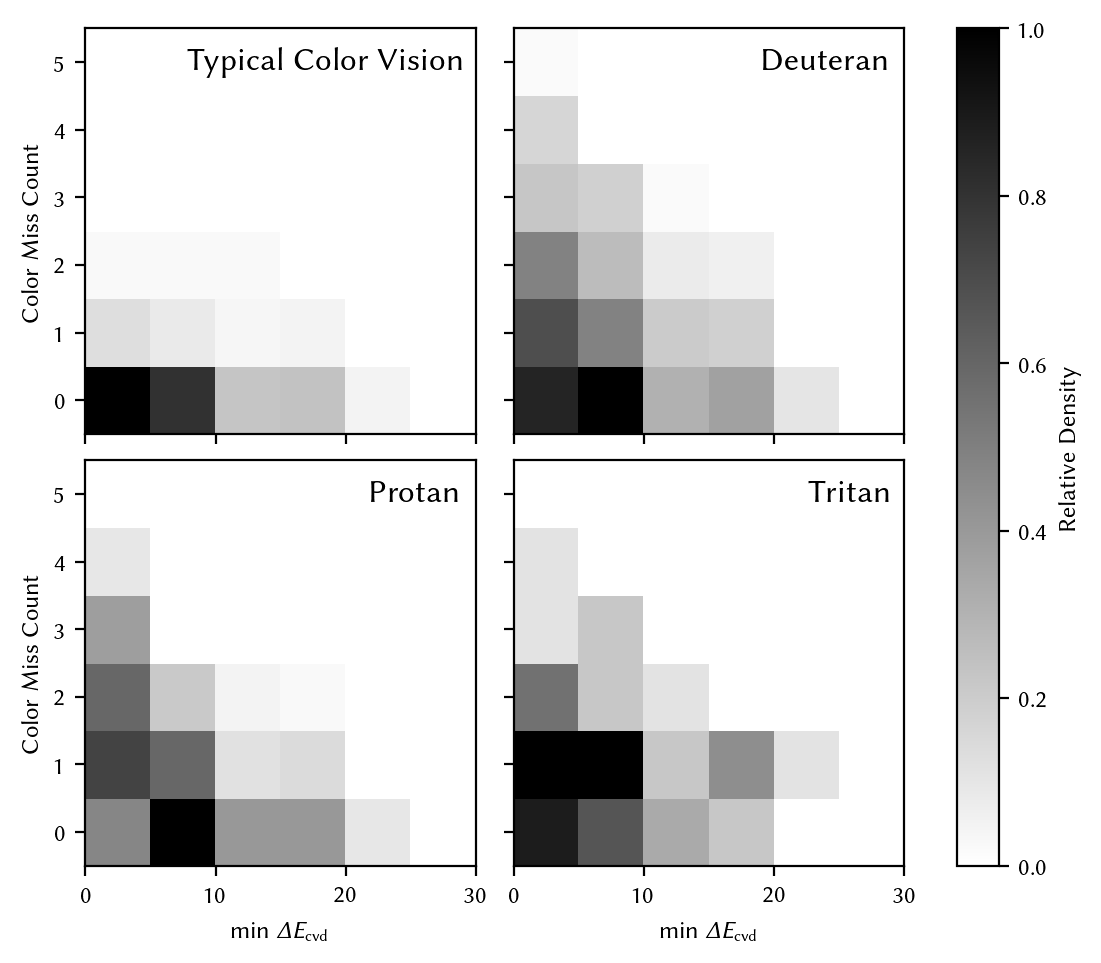

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(5.4, 4.7), sharex=True, sharey=True, layout="constrained")
titles = {
    "typ": "Typical Color Vision",
    "deut": "Deuteran",
    "prot": "Protan",
    "trit": "Tritan",
}
totalMaxError = 0
for i, visType in enumerate(responses):
    data = []
    maxError = 0
    while True:
        d = []
        for resp in responses[visType]:
            d.append(minDeltaE[np.maximum(numColor - resp[0], 0) == maxError])
        d = np.concatenate(d)
        if d.size > 0:
            maxError += 1
            data.append(d)
        else:
            totalMaxError = max(totalMaxError, maxError)
            break

    miss_count = []
    for j in range(len(data)):
        miss_count += [j] * data[j].size
    
    data = np.concatenate(data)
    #ax.flatten()[i].hist2d(data, miss_count, bins=(6, 6), range=[[0, 30], [-0.5, 5.5]], cmap="gray_r")
    # Duplicate hist2d method but use pcolor instead of pcolormesh, so polygons can be
    # extended to avoid gaps sometimes appearing in PDF rendering due to antialiasing
    # https://github.com/matplotlib/matplotlib/issues/1188
    h, xedges, yedges = np.histogram2d(data, miss_count, bins=(6, 6), range=[[0, 30], [-0.5, 5.5]], density=False, weights=None)
    pc = ax.flatten()[i].pcolor(xedges, yedges, h.T, cmap="gray_r")
    paths = [p.vertices[:4] for p in pc.get_paths()]
    for p in paths:
        p[2:, 0] += (p[2, 0] - p[0, 0]) * 0.1
        p[1:3, 1] += (p[1, 1] - p[0, 1]) * 0.1
    pc.set_paths(paths)
    
    if i % 2 == 0:
        ax.flatten()[i].set_ylabel("Color Miss Count")
    if i > 1:
        ax.flatten()[i].set_xlabel("min $\Delta E_\mathrm{cvd}$")
    ax.flatten()[i].text(29, 5, titles[visType], fontsize=12, ha="right", va="center")

ax[0, 0].set_yticks(range(totalMaxError))
ax[0, 0].set_xlim(0, 30)

fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap="gray_r"), ax=ax, label="Relative Density")

plt.savefig("metric-validation.pdf")